# SUSY Analysis Challenge 2018

**EWK 2L and 3L chargino/neutralino model**

*Solution provided by Knut Vadla, University of Oslo*

## Binary classification with XGBoost

The results have been obtained using the Python machine learning libraries scikit-learn (as common API, and for the AdaBoost BDT), XGBoost and Keras+TensorFlow (for the neural network).

After trying out two different boosted decision tree models
- AdaBoost: Adaptive boosting with decision stumps (only one level deep),
- XGBoost: Gradient boosting with weak learners (default: max three levels deep),

and a simple artificial neural network

- Densely connected, shallow (one hidden layer), feed-forward neural network,

I ended up getting the strongest results from the XGBoost BDT.

The setup yielding the largest significance was in fact running with the default hyperparameters – perhaps the most important ones being:
- max_depth = 3 (tree depth)
- learning_rate = 0.1 (below one to slow down learning – avoid overfitting)
- n_estimators = 100 (number of trees in the ensemble)

## Fetching the scripts and data files

The folder with the ML framework can be found on EOS at: 
```
/eos/user/k/kvadla/SWAN_projects/SUSYAnalysisChallenge2018
```

and the folder with scripts to flatten and add new variables to the original ntuples, the flattened ntuples themselves and the hdf5 files used as inputs to the machine learning framework, can be found at: 
```
/eos/user/k/kvadla/ewk
```

## How to convert ntuples to hdf5 files

- Open a fresh terminal on lxplus (or a computer with access to the ATLAS software) and navigate to the `ewk` folder containing the MakeSelector scripts `AC18_2L_selector.C` and `AC18_3L_selector.C` (and their respective header files), and the input ntuples (I have placed them in the folder called `ntuples`).
- Run `setupATLAS` and set up an Analysis release, e.g. 
```
asetup AnalysisBase,21.2.20
```
- Before converting, say, a 2L signal file, open the script `AC18_2L_selector.C`. To make sure the output file name will be set correctly, check that line 45 says `isSignal = true` (set to false for background ntuple).
- Open an interactive ROOT session with the ntuple to be converted attached, e.g.
```
root -l ntuples/2L_sig.root
```
- To read in the ntuple, flatten it and calculate and add new variables, run
```
tree_NoSys->Process("AC18_2L_selector.C")
```
- The flattened and extended ntuple is now stored in the folder `flat_ntuples` with name `2L_sig_flat_ext.root`.
- To convert the flat ntuple to the hdf5 format, and store it in the folder `hdf5_files`, run the following command
```
ttree2hdf5 --in-file flat_ntuples/2L_sig_flat_ext.root --out-file hdf5_files/2L_sig_flat_ext.h5
```

The data is now ready to be read in by the machine learning framework.

## Run classification on input data with a pre-trained model

First, we need to specify which hdf5 files to read in – one for background and one for signal. This can be done in the `SUSYAnalysisChallenge2018/MLClassifier/classifiers.py` script, in line 139 for background and in line 164 for signal. By default, these files are read from the `ewk/hdf5_files` folder, with the file name convention `<final_state>_bkg_flat_ext.h5` for background, and correspondingly for signal, where `<final_state>` is specified at the command line as either `2L` or `3L`.

The pre-trained XGBoost models can be found in the folder `SUSYAnalysisChallenge2018/MLClassifier`, and are called `xgboost_2L_AC18.pkl` and `xgboost_3L_AC18.pkl` for the 2L and 3L channels, respectively. `classifiers.py` is already set up to read them in – no changes should be needed.

In order to read in the hdf5 files, we need to import the `h5py` module. This can be done by clicking in the cell below, and running the import command by pressing `Ctrl-Enter`:

In [143]:
import h5py

Then, the pre-trained XGBoost classifier for the 2L channel can be run by executing the command in the cell below. A histogram with the background and signal yields in the signal region, with uncertainties calculated as the square root of the sum of event weights squared, is saved as a ROOT file called `output_xgboost_2L_flat_ext_ew_cw.root`.


deselected_features ['dsid', 'event_weight', 'lep_charge1', 'lep_charge2', 'n_bjets']

selected_features = ['dPhi_jj_ll', 'dPhi_jj_met', 'dPhi_ll_met', 'dR_jj', 'dR_ll', 'jet_eta1', 'jet_eta2', 'jet_eta3', 'jet_m1', 'jet_m2', 'jet_m3', 'jet_phi1', 'jet_phi2', 'jet_phi3', 'jet_pt1', 'jet_pt2', 'jet_pt3', 'lep_eta1', 'lep_eta2', 'lep_phi1', 'lep_phi2', 'lep_pt1', 'lep_pt2', 'met', 'met_phi', 'mjj', 'mll', 'n_jets', 'pt_jj', 'pt_ll']

n_selected_features = 30

Read in background file: ../../../ewk/hdf5_files/2L_bkg_flat_ext.h5
Read in signal file: ../../../ewk/hdf5_files/2L_sig_flat_ext.h5

class_weight_vect [   0.5   154.33]
class_weight_dict {0: 0.50162522222815675, 1: 154.32511737089203}

scale_pos_weight 308.650234742

before imp: np.any(X_bkg_sel_arr == -999) True
before imp: np.any(X_bkg_shuffled == -999) True
after imp: np.any(X == -999) False

# training examples:
Background  : 175618
Signal      : 571

# test examples:
Background  : 86500
Signal      : 281

INFO  Applying event 

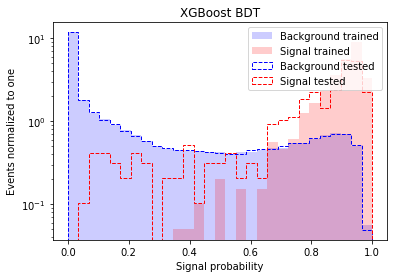

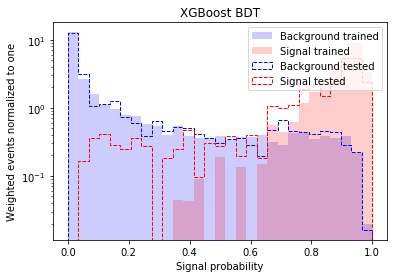

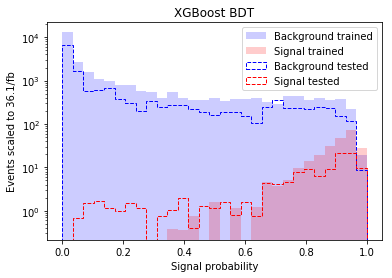

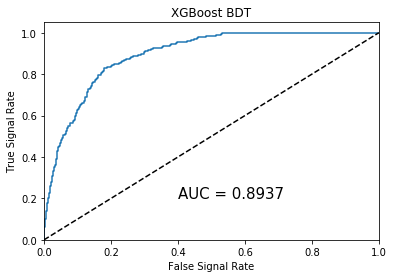

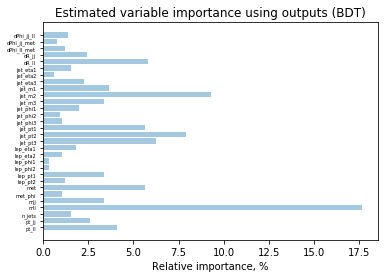

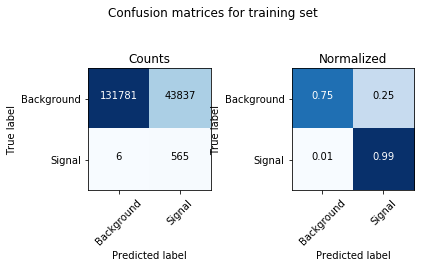

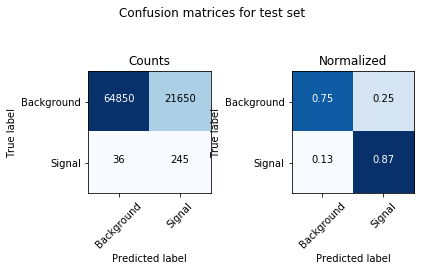


Training sample....
  Signal identified as signal (%)        :  98.9492119089
  Signal identified as background (%)    :  1.05078809107
  Background identified as signal (%)    :  24.9615643043
  Background identified as background (%):  75.0384356957

Testing sample....
  Signal identified as signal (%)        :  87.1886120996
  Signal identified as background (%)    :  12.8113879004
  Background identified as signal (%)    :  25.0289017341
  Background identified as background (%):  74.9710982659

Area under ROC =  0.893673461831

sum_weights_test_sig 17.3872814104
sum_weights_test_bkg 85.9520978546

acceptance_sig 0.333333333333
acceptance_bkg 0.333333333333

*************************************************
Optimized cut value =  0.9
*************************************************
Event yields in optimized SR:
S = 52.1618442312 +/- 5.75268428558
B = 257.856293564 +/- 29814.0117537
*************************************************
Optimized AMS score (br=0) =  3.1471555581
Optimi

In [150]:
%run classifiers.py --xgboost --final_state 2L --class_weights --no_training

And to run the corresponding pre-trained XGBoost classifier for the 3L channel, execute the command below. The ROOT file with the output histogram of signal regions yields with uncertainties, are saved as `output_xgboost_3L_flat_ext_ew_cw.root`.


deselected_features ['dsid', 'event_weight', 'lep_charge1', 'lep_charge2', 'n_bjets']

selected_features = ['jet_eta1', 'jet_m1', 'jet_phi1', 'jet_pt1', 'lep_eta1', 'lep_eta2', 'lep_eta3', 'lep_phi1', 'lep_phi2', 'lep_phi3', 'lep_pt1', 'lep_pt2', 'lep_pt3', 'met', 'mll', 'mt_min', 'n_jets', 'pt_lll']

n_selected_features = 15

Read in background file: ../../../ewk/hdf5_files/3L_bkg_flat_ext.h5
Read in signal file: ../../../ewk/hdf5_files/3L_sig_flat_ext.h5

class_weight_vect [   0.5   110.83]
class_weight_dict {0: 0.5022658864565307, 1: 110.83209509658246}

scale_pos_weight 221.664190193

before imp: np.any(X_bkg_sel_arr == -999) False
before imp: np.any(X_bkg_shuffled == -999) False
after imp: np.any(X == -999) False

# training examples:
Background  : 298498
Signal      : 1353

# test examples:
Background  : 147023
Signal      : 666

INFO  Applying event weights to the examples during training

model.get_params() {'reg_alpha': 0, 'n_jobs': 1, 'colsample_bytree': 1, 'silent': True, '

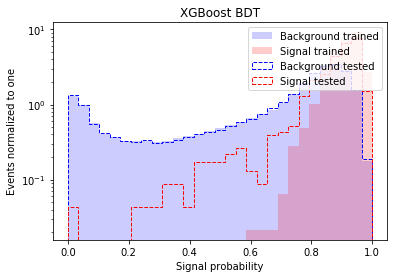

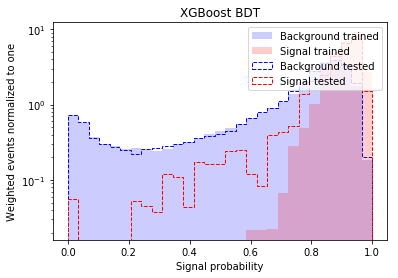

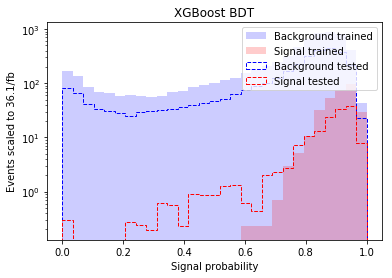

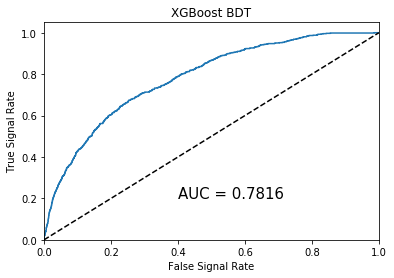

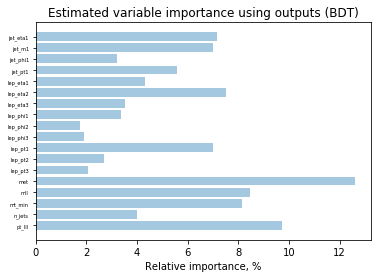

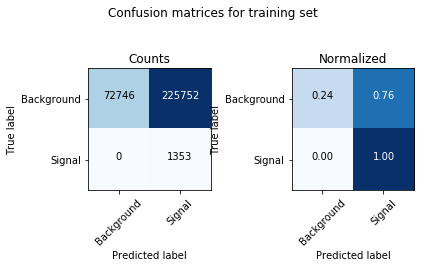

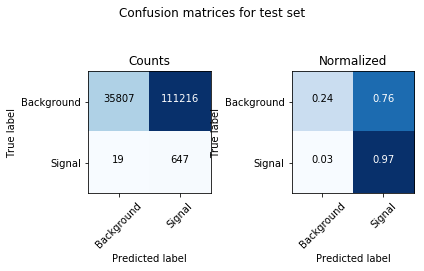


Training sample....
  Signal identified as signal (%)        :  100.0
  Signal identified as background (%)    :  0.0
  Background identified as signal (%)    :  75.6293174494
  Background identified as background (%):  24.3706825506

Testing sample....
  Signal identified as signal (%)        :  97.1471471471
  Signal identified as background (%)    :  2.85285285285
  Background identified as signal (%)    :  75.6453071968
  Background identified as background (%):  24.3546928032

Area under ROC =  0.781603862965

sum_weights_test_sig 0.0
sum_weights_test_bkg 0.0285918004811

acceptance_sig 0.333333333333
acceptance_bkg 0.333333333333

*************************************************
Optimized cut value =  0.9
*************************************************
Event yields in optimized SR:
S = 77.9324929342 +/- 3.85678278512
B = 575.391809442 +/- 48.6062175699
*************************************************
Optimized AMS score (br=0) =  3.17941619657
Optimized AMS score (br=10) =  

In [151]:
%run classifiers.py --xgboost --final_state 3L --class_weights --cut_scan

## Training, validating and testing the performance

The background and signal events are first read into separate arrays, shuffled and concatenated to one large numpy ndarray. Then, scikit-learn's `train_test_split()` function splits the full dataset into a training set (2/3 of the events) and a test set (1/3 of the events). The parameter `stratify` is given the array holding the ground truth lables of the class id for each event, and will then maintain the same class proportions in the training and test sets as the full dataset.

To enable grid search for optimal hyperparameters, the training performance is evaluated by a 3-fold cross-validation. The training set is randomly divided into three parts, where two parts are used for the first round of training and the resulting performance evaluated on the held out third set. This procedure continues until all parts have been held out once. In this way the full training set can be used for both training and validation, without the need for a separate validation set – which would have taken away a valuable portion of an already limited number of events for training.

Because the datasets are unbalanced, i.e. we have much more background events than signal events available, I apply a class weight to the signal events, `class_weight = n_events_tot/n_sig_events`, to balance the emphasis given to each class during training. In this way I am able to use the full statistics of the background sample as well. The BDTs appear to handle the class weights well, without overtraining on background, even though there are approximately three orders of magnitude more background events than signal events.

The output of the XGBoost classifier is a signal probability, where I am performing a scan over cut values to find the signal region which maximizes the signal significance. The significance metric I have used for this optimization is the Approximate Mean Significance (AMS)

$$AMS = \sqrt{2(s+b+b_r)log\left(1+\frac{s}{b+b_r}-s\right)},$$

where the default value $b_r = 10$ is called a constant regularization term. AMS was the metric of evaluation in the Kaggle Higgs Machine Learning Challenge in 2014 (see https://www.kaggle.com/c/higgs-boson#evaluation).

Since 2/3 of the events have been used to train the classifier, they can not be used as independent/"blinded" events to estimate the final signal region yields. The way I have solved this is to divide the event yields by an acceptance factor of "1/3" for the test set, which means multiplying all events by three to be able to estimate the expected background and signal yields in the signal region with a luminosity of 36.1/fb. I am not sure this is the optimal (or even correct) way of obtaining these estimates. In particlular, this acceptance scale factor also enters the uncertainty calculations, and leads, together with some quite large event weights, to incredibly large uncertainties on the signal region yields – even orders of magnitude larger than the estimated yields.

I have therefore chosen to supply two sets (four bins) of SR yield estimates in the SR histogram: signal and background yields with uncertainties calculated as $\sqrt{\sum_i w_i^2}$, where the $w_i$s represent the nominal event weights as taken directly from the provided ntuples; and another set with signal and bakcground yields where uncertainties are calculated as $\sqrt{\sum_i (w_i/\alpha)^2}$, where $\alpha$ represents the acceptance. The combination of low signal statistics, some large event weights of O(10) and the upscaling of the test events to account for the lost training statistics, unfortunately seem to be quite detrimental to the error estimates.

## Appendix: Run the pre-trained AdaBoost classifiers

The AdaBoost classifier did also show good performance, and can be run by executing the below commands:


deselected_features ['dsid', 'event_weight', 'lep_charge1', 'lep_charge2', 'n_bjets']

selected_features = ['dPhi_jj_ll', 'dPhi_jj_met', 'dPhi_ll_met', 'dR_jj', 'dR_ll', 'jet_eta1', 'jet_eta2', 'jet_eta3', 'jet_m1', 'jet_m2', 'jet_m3', 'jet_phi1', 'jet_phi2', 'jet_phi3', 'jet_pt1', 'jet_pt2', 'jet_pt3', 'lep_eta1', 'lep_eta2', 'lep_phi1', 'lep_phi2', 'lep_pt1', 'lep_pt2', 'met', 'met_phi', 'mjj', 'mll', 'n_jets', 'pt_jj', 'pt_ll']

n_selected_features = 30

Read in background file: ../../../ewk/hdf5_files/2L_bkg_flat_ext.h5
Read in signal file: ../../../ewk/hdf5_files/2L_sig_flat_ext.h5

class_weight_vect [   0.5   154.33]
class_weight_dict {0: 0.50162522222815675, 1: 154.32511737089203}

scale_pos_weight 308.650234742

before imp: np.any(X_bkg_sel_arr == -999) True
before imp: np.any(X_bkg_shuffled == -999) True
after imp: np.any(X == -999) False

# training examples:
Background  : 175611
Signal      : 578

# test examples:
Background  : 86507
Signal      : 274

INFO  Applying event 

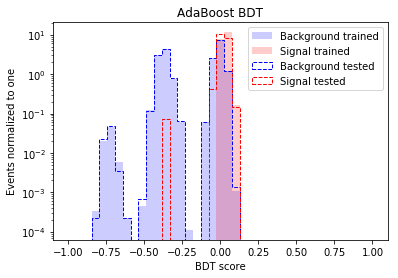

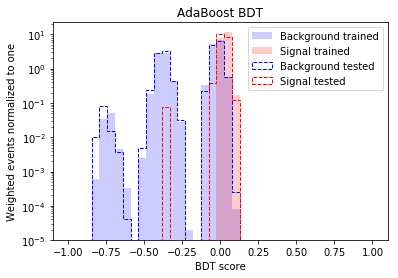

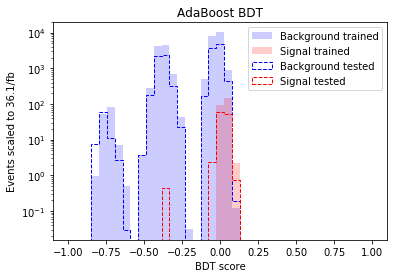

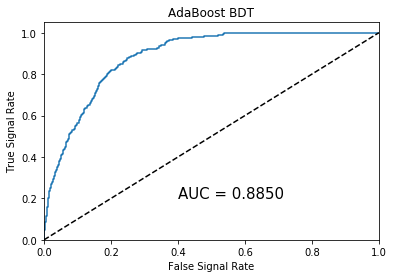

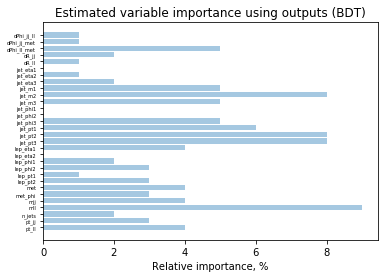

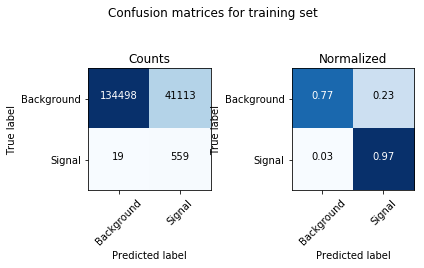

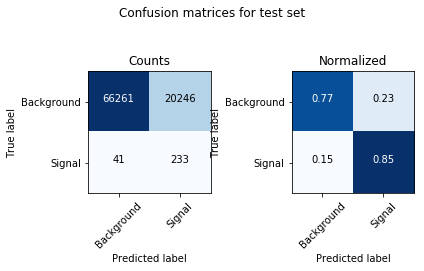


Training sample....
  Signal identified as signal (%)        :  96.7128027682
  Signal identified as background (%)    :  3.28719723183
  Background identified as signal (%)    :  23.4114036137
  Background identified as background (%):  76.5885963863

Testing sample....
  Signal identified as signal (%)        :  85.0364963504
  Signal identified as background (%)    :  14.9635036496
  Background identified as signal (%)    :  23.4038863907
  Background identified as background (%):  76.5961136093

Area under ROC =  0.884971926241

sum_weights_test_sig 32.6076868996
sum_weights_test_bkg 724.26185784

acceptance_sig 0.333333333333
acceptance_bkg 0.333333333333

*************************************************
Optimized cut value =  0.0
*************************************************
Event yields in optimized SR:
S = 97.8230606988 +/- 5.55853309364
B = 2172.78557352 +/- 29155.1622537
*************************************************
Optimized AMS score (br=0) =  2.0831561495
Optimiz

In [131]:
%run classifiers.py --adaboost --final_state 2L --class_weights --no_training


deselected_features ['dsid', 'event_weight', 'lep_charge1', 'lep_charge2', 'n_bjets']

selected_features = ['jet_eta1', 'jet_m1', 'jet_phi1', 'jet_pt1', 'lep_eta1', 'lep_eta2', 'lep_eta3', 'lep_phi1', 'lep_phi2', 'lep_phi3', 'lep_pt1', 'lep_pt2', 'lep_pt3', 'met', 'mll', 'mt_min', 'n_jets', 'pt_lll']

n_selected_features = 15

Read in background file: ../../../ewk/hdf5_files/3L_bkg_flat_ext.h5
Read in signal file: ../../../ewk/hdf5_files/3L_sig_flat_ext.h5

class_weight_vect [   0.5   110.83]
class_weight_dict {0: 0.5022658864565307, 1: 110.83209509658246}

scale_pos_weight 221.664190193

before imp: np.any(X_bkg_sel_arr == -999) False
before imp: np.any(X_bkg_shuffled == -999) False
after imp: np.any(X == -999) False

# training examples:
Background  : 298505
Signal      : 1346

# test examples:
Background  : 147016
Signal      : 673

INFO  Applying event weights to the examples during training

Reading in pre-trained BDT

X_bkg_dset.shape[0] 445521
X_bkg_sel_shuffled.shape[0] 445521

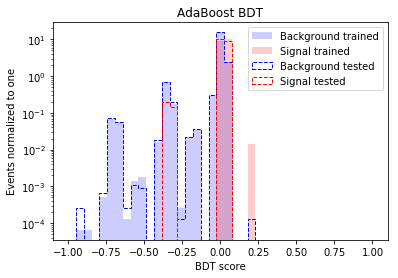

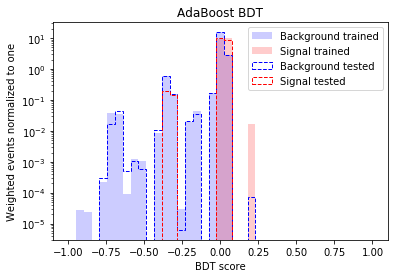

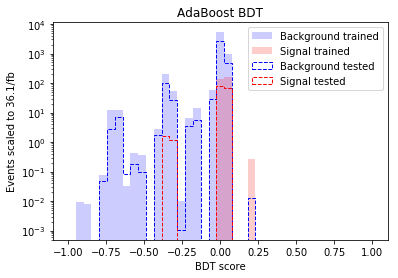

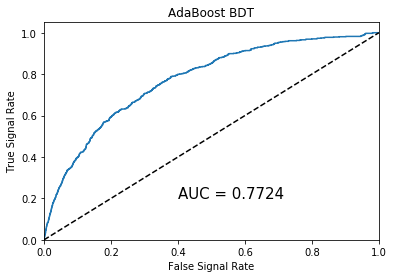

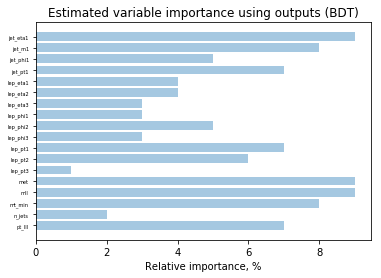

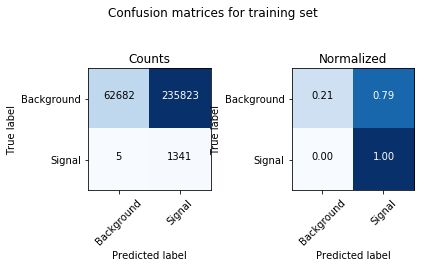

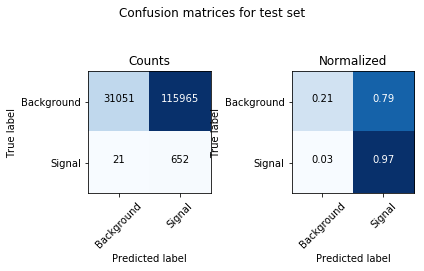


Training sample....
  Signal identified as signal (%)        :  99.6285289747
  Signal identified as background (%)    :  0.37147102526
  Background identified as signal (%)    :  79.0013567612
  Background identified as background (%):  20.9986432388

Testing sample....
  Signal identified as signal (%)        :  96.8796433878
  Signal identified as background (%)    :  3.12035661218
  Background identified as signal (%)    :  78.8791696142
  Background identified as background (%):  21.1208303858

Area under ROC =  0.772442685682

sum_weights_test_sig 48.9059097655
sum_weights_test_bkg 936.208457564

acceptance_sig 0.333333333333
acceptance_bkg 0.333333333333

*************************************************
Optimized cut value =  0.0
*************************************************
Event yields in optimized SR:
S = 146.717729297 +/- 3.85663156637
B = 2808.62537269 +/- 52.030657919
*************************************************
Optimized AMS score (br=0) =  2.74485049149
Optimi

In [133]:
%run classifiers.py --adaboost --final_state 3L --class_weights --no_training